In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# 3months worh of upcoming acquitions
df1 = pd.read_csv('access_30.csv') # next 30 days
df2 = pd.read_csv('access_60.csv') # 30-60 days
df3 = pd.read_csv('access_90.csv') # 60-90 days
df = pd.concat([df1,df2,df3], ignore_index=True)
print(len(df))
df.head(3)

78


,center,centerEcef,spacecraftId,accessId,accessrequestId,tileId,windowOpen,windowClose,windowOpenLocal,windowCloseLocal,orbitalPlane,accessProperties.ascdsc,accessProperties.lookDirection,accessProperties.localTime,accessProperties.azimuthOpen,accessProperties.azimuthClose,accessProperties.elevationMin,accessProperties.elevationMax,accessProperties.offNadirMin,accessProperties.offNadirMax
0,"[-121.74465241003678, 46.79643716990961, 1589]","[-2301995.729910036, -3720759.6812200774, 4627...",6,eddecdf8-8ddd-49e7-bff5-0e83f8dda622,b2b485db-b51b-469a-b091-8f5a4e7b1994,b62a0f08-7b35-4fee-a0b4-5b18f2a794f7,2023-11-11T13:14:34.713Z,2023-11-11T13:15:47.818Z,2023-11-11T05:14:34.713Z,2023-11-11T05:15:47.818Z,53,descending,right,18474,345.383003,58.717093,46.247575,52.725877,34.259856,39.999527
1,"[-121.74447555476563, 46.79643719172761, 1589]","[-2301984.2440745146, -3720766.785284324, 4627...",6,c4b45b73-dac2-477a-a80b-3ca969e77ef7,b2b485db-b51b-469a-b091-8f5a4e7b1994,f3959dbc-cf7e-4631-aca7-e500f074fe12,2023-11-12T09:30:16.139Z,2023-11-12T09:30:58.775Z,2023-11-12T01:30:16.139Z,2023-11-12T01:30:58.775Z,53,ascending,right,5000,319.296493,359.997365,46.243551,48.174043,38.302421,39.998892
2,"[-121.74465241003678, 46.79643716990961, 1589]","[-2301995.729910036, -3720759.6812200774, 4627...",6,32ce652d-d9ca-459c-9936-16b5783b96f0,b2b485db-b51b-469a-b091-8f5a4e7b1994,b62a0f08-7b35-4fee-a0b4-5b18f2a794f7,2023-11-12T12:47:24.487Z,2023-11-12T12:48:21.122Z,2023-11-12T04:47:24.487Z,2023-11-12T04:48:21.122Z,53,descending,right,16836,353.455556,48.561634,46.247253,49.830512,36.840097,39.999266


In [4]:
def summarize_df(df):
    print(len(df), df.windowOpenLocal.iloc[0], df.windowOpenLocal.iloc[-1])
    
[summarize_df(x) for x in [df1,df2,df3]]

27 2023-11-11T05:14:34.713Z 2023-12-05T21:08:17.236Z
19 2023-12-15T11:39:54.430Z 2024-01-04T09:07:30.427Z
32 2024-01-05T03:45:10.151Z 2024-01-31T23:39:27.507Z


[None, None, None]

In [5]:
# No Capella-11
df.spacecraftId.unique()

array([6])

In [6]:
# Forgot to sort when saving
df['windowOpenLocal'] = pd.to_datetime(df.windowOpenLocal)
df = df.sort_values('windowOpenLocal', ignore_index=True)

In [7]:
df.windowOpenLocal.is_monotonic_increasing

True

In [8]:
access_df_summary = df.groupby(['orbitalPlane',
            'accessProperties.ascdsc', 
            'accessProperties.lookDirection'
           ]).agg(passCount=('windowOpen', 'count')
                 #  LookDirAzimuth=('LookDirectionAzimuth[degrees]', 'mean'),
                 # LookDirAzimuthStd=('LookDirectionAzimuth[degrees]', 'std'),
                 #  SatAzimuth = ('SatelliteAzimuth[degrees]', 'mean')
                 ).reset_index().rename(columns = {'accessProperties.ascdsc': 'orbitState', 'accessProperties.lookDirection': 'lookDirection'})
access_df_summary

,orbitalPlane,orbitState,lookDirection,passCount
0,53,ascending,left,12
1,53,ascending,right,26
2,53,descending,left,17
3,53,descending,right,23


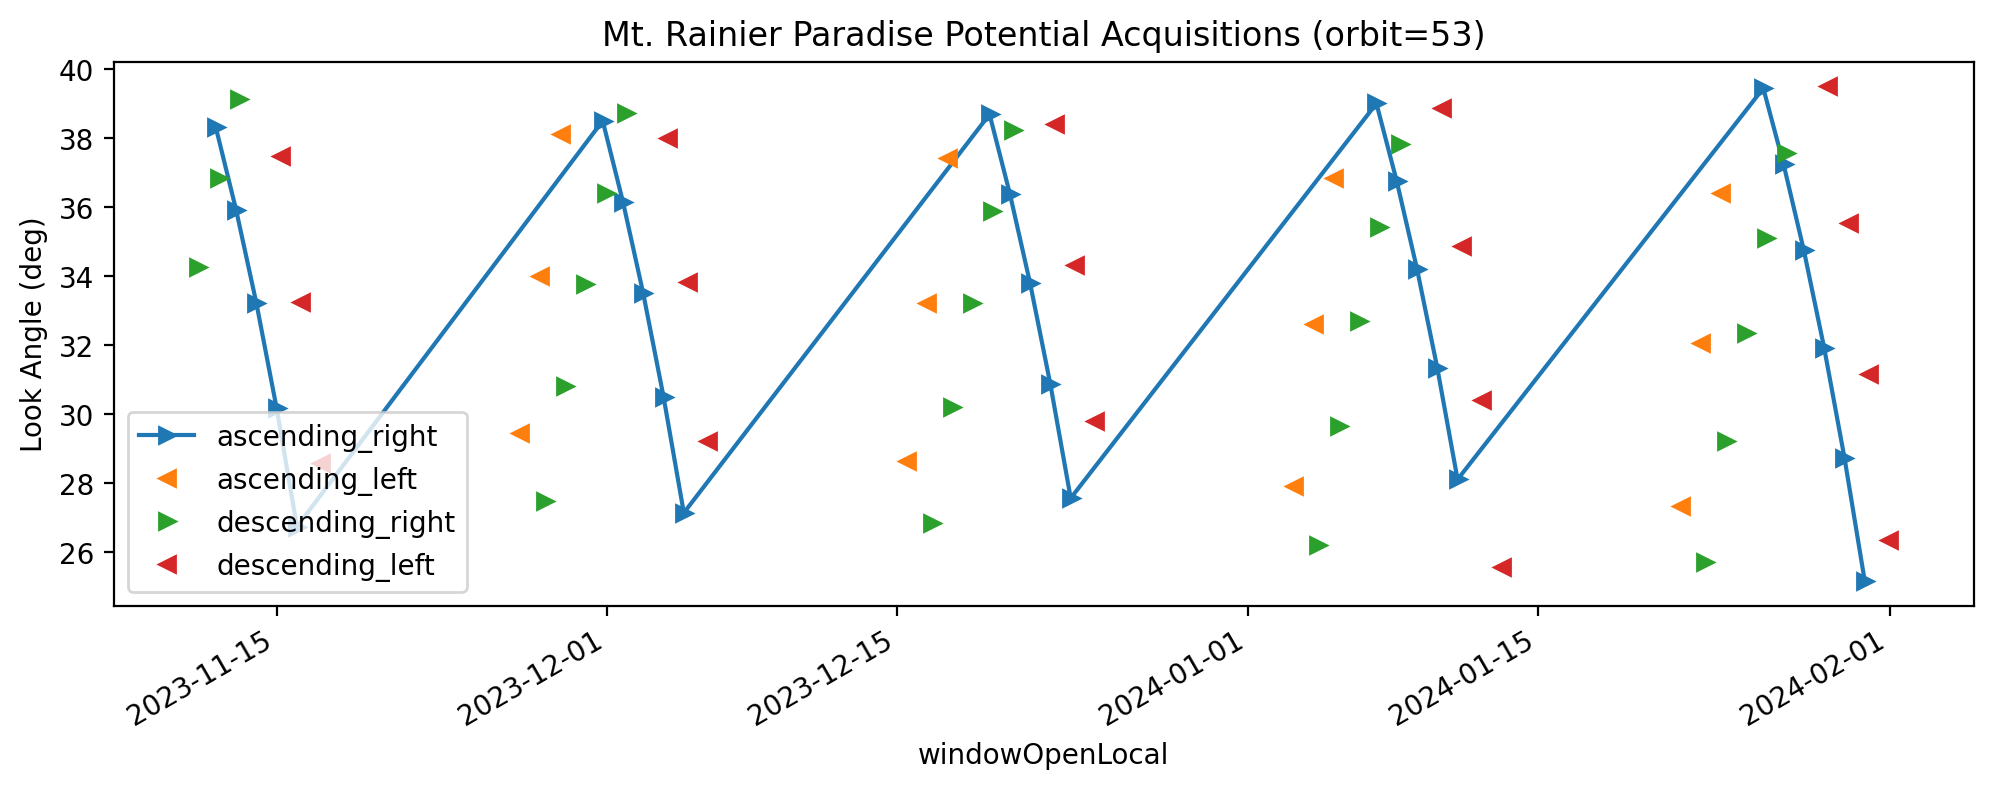

In [9]:
# # For a given combination of orbitState and lookDirection, how do acquisitions vary over time?
# Use STAC Names for anaylsis
df = df.rename(columns = {'accessProperties.ascdsc': 'orbit_state', 
                           'accessProperties.lookDirection': 'observation_direction',
                           'accessProperties.offNadirMin': 'look_angle'}) # Match console

ar = df[(df.orbit_state == 'ascending') & (df.observation_direction == 'right')]

al = df[(df.orbit_state == 'ascending') & (df.observation_direction == 'left')]

dr = df[(df.orbit_state == 'descending') & (df.observation_direction == 'right')]

dl = df[(df.orbit_state == 'descending') & (df.observation_direction == 'left')]

fig,ax = plt.subplots(figsize=(12,4))
ar.plot(x='windowOpenLocal', y='look_angle', marker='>', label='ascending_right', ax=ax)
al.plot(x='windowOpenLocal', y='look_angle', marker='<', label='ascending_left', ax=ax, linestyle='none')
dr.plot(x='windowOpenLocal', y='look_angle', marker='>', label='descending_right', ax=ax, linestyle='none')
dl.plot(x='windowOpenLocal', y='look_angle', marker='<', label='descending_left', ax=ax, linestyle='none')
#df.plot(x='windowOpenLocal', y='look_angle', marker='none', ax=ax)
plt.ylabel('Look Angle (deg)')
plt.title('Mt. Rainier Paradise Potential Acquisitions (orbit=53)');

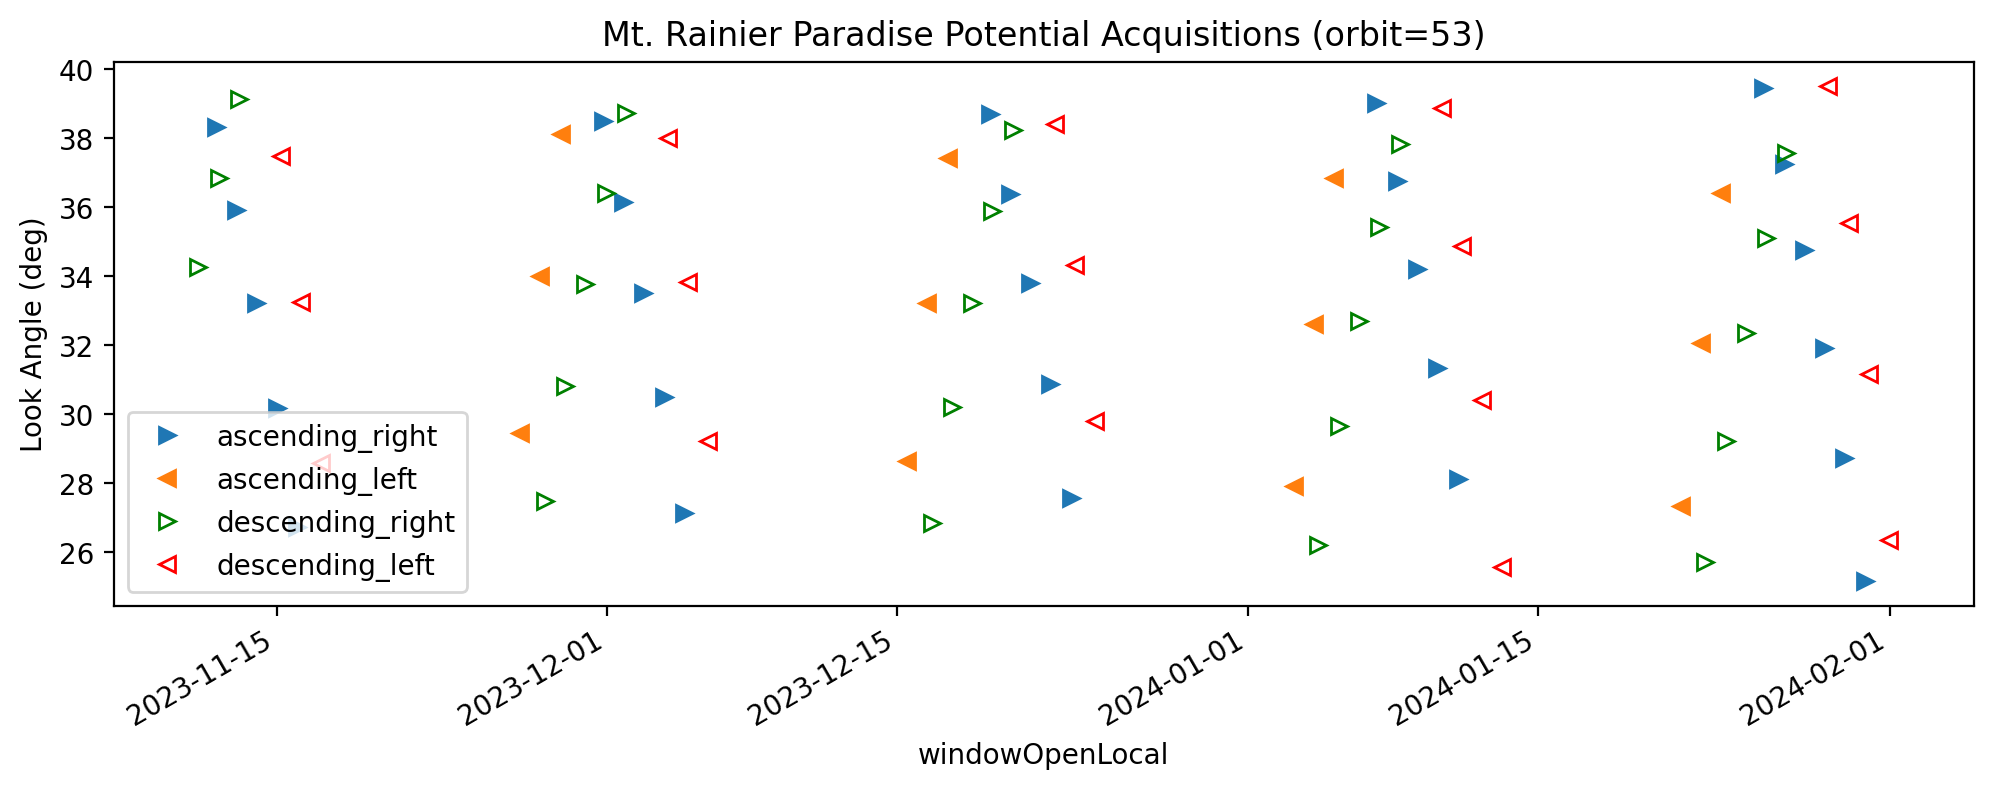

In [10]:
fig,ax = plt.subplots(figsize=(12,4))
ar.plot(x='windowOpenLocal', y='look_angle', marker='>', label='ascending_right', ax=ax, linestyle='none')
al.plot(x='windowOpenLocal', y='look_angle', marker='<', label='ascending_left', ax=ax, linestyle='none')
dr.plot(x='windowOpenLocal', y='look_angle', marker='>', label='descending_right', ax=ax, mec='g', mfc='none', linestyle='none')
dl.plot(x='windowOpenLocal', y='look_angle', marker='<', label='descending_left', ax=ax, mec='r', mfc='none', linestyle='none')
#df.plot(x='windowOpenLocal', y='look_angle', marker='none', ax=ax)
plt.ylabel('Look Angle (deg)')
plt.title('Mt. Rainier Paradise Potential Acquisitions (orbit=53)');

In [11]:
# Time difference for all acquisition types
df['time_diff'] = df.windowOpenLocal.diff(1)
cols = ['windowOpenLocal','orbit_state','observation_direction','time_diff']
#df[cols].sort_values('time_diff')
df.time_diff.describe()

count                           77
mean     1 days 01:29:09.257064935
std      1 days 23:42:28.907377008
min         0 days 03:16:53.865000
25%         0 days 04:55:35.740000
50%         0 days 18:37:44.961000
75%         0 days 23:32:35.044000
max         9 days 14:31:40.364000
Name: time_diff, dtype: object

In [12]:
df[cols].head(15) # NOTE: 9 day gap of no observations 11-17 to 11-26

,windowOpenLocal,orbit_state,observation_direction,time_diff
0,2023-11-11 05:14:34.713000+00:00,descending,right,NaT
1,2023-11-12 01:30:16.139000+00:00,ascending,right,0 days 20:15:41.426000
2,2023-11-12 04:47:24.487000+00:00,descending,right,0 days 03:17:08.348000
3,2023-11-13 01:02:47.163000+00:00,ascending,right,0 days 20:15:22.676000
4,2023-11-13 04:20:18.675000+00:00,descending,right,0 days 03:17:31.512000
5,2023-11-14 00:35:21.310000+00:00,ascending,right,0 days 20:15:02.635000
6,2023-11-15 00:07:57.160000+00:00,ascending,right,0 days 23:32:35.850000
7,2023-11-15 05:03:39.822000+00:00,descending,left,0 days 04:55:42.662000
8,2023-11-15 23:40:34.236000+00:00,ascending,right,0 days 18:36:54.414000
9,2023-11-16 04:36:09.976000+00:00,descending,left,0 days 04:55:35.740000


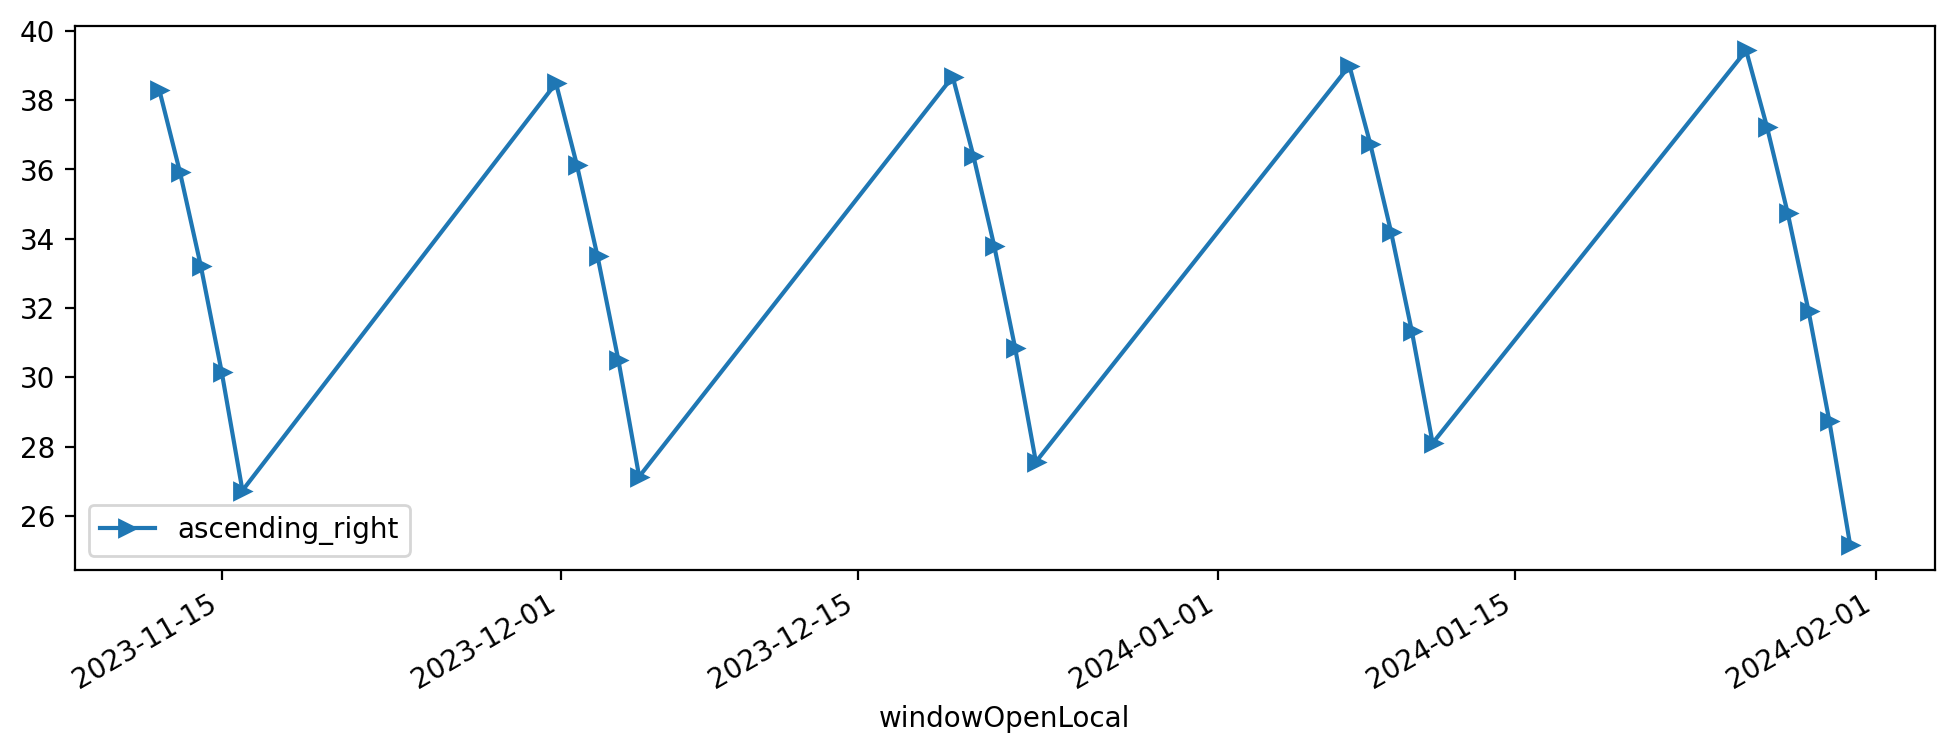

In [13]:
fig,ax = plt.subplots(figsize=(12,4))
ar.plot(x='windowOpenLocal', y='look_angle', marker='>', label='ascending_right', ax=ax);

In [14]:
# NOT sure how mutually exclusive acquisitions are (switching left/right)
# NOTE: can get acquisitions 3 hours later if sticking with 'right'
cols = ['windowOpenLocal','orbit_state','observation_direction']
df[cols].head()

,windowOpenLocal,orbit_state,observation_direction
0,2023-11-11 05:14:34.713000+00:00,descending,right
1,2023-11-12 01:30:16.139000+00:00,ascending,right
2,2023-11-12 04:47:24.487000+00:00,descending,right
3,2023-11-13 01:02:47.163000+00:00,ascending,right
4,2023-11-13 04:20:18.675000+00:00,descending,right


<Axes: xlabel='windowOpenLocal'>

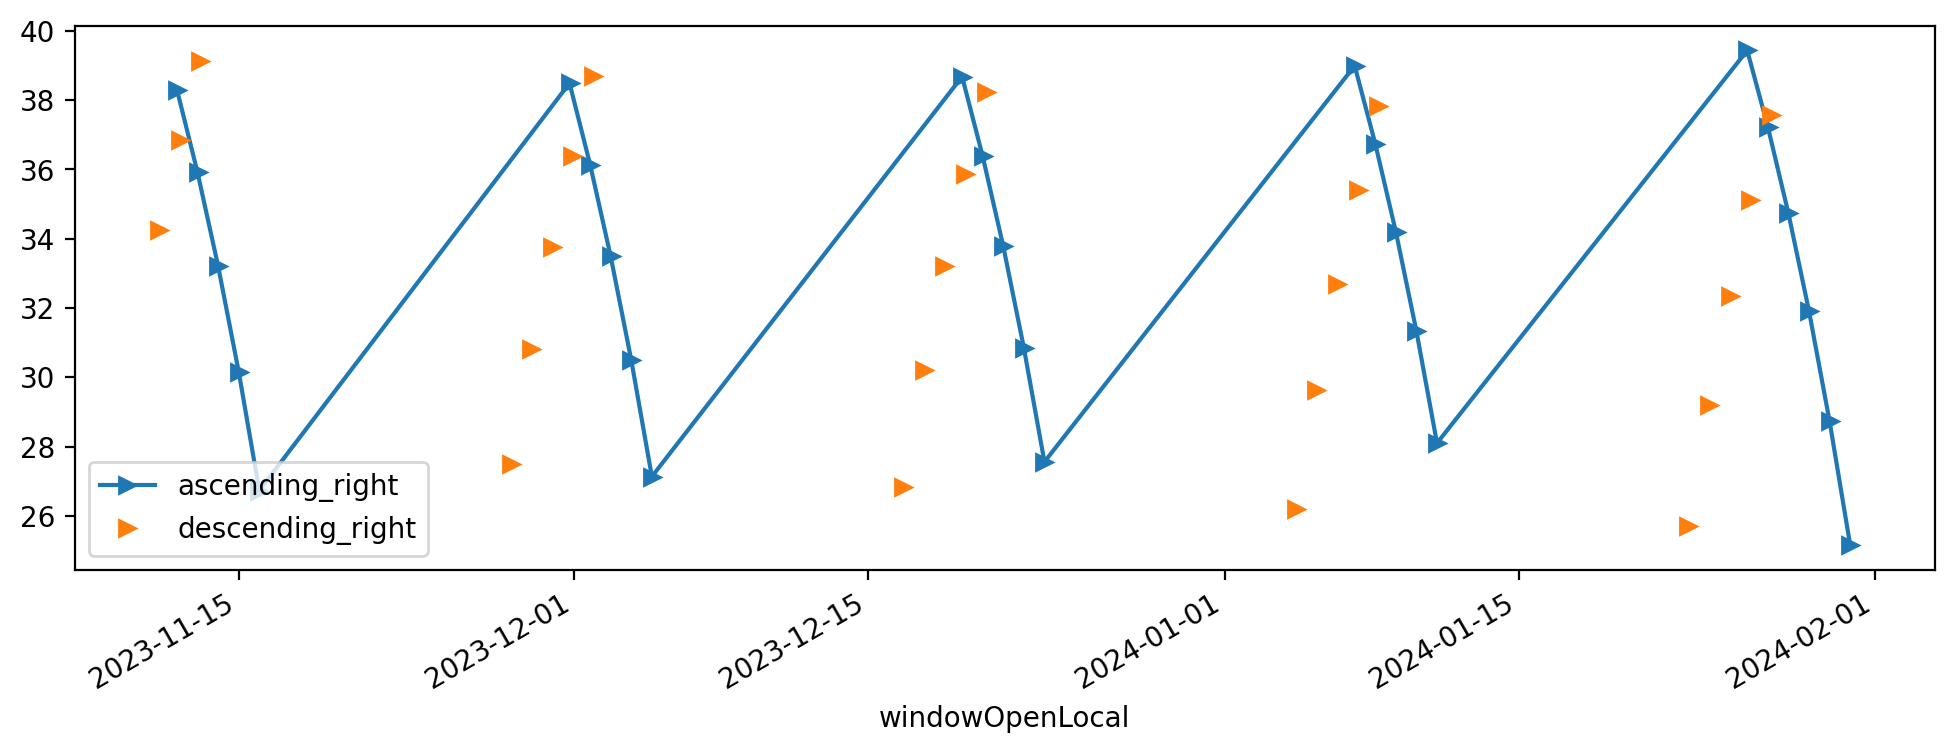

In [15]:
# Perhaps we get ascending right
ind_ar = (df.orbit_state == 'ascending') & (df.observation_direction == 'right')
ind_dr = (df.orbit_state == 'descending') & (df.observation_direction == 'right')
#df[ind_ar | ind_dr].plot(x='windowOpenLocal', y='look_angle')
fig,ax = plt.subplots(figsize=(12,4))
ar.plot(x='windowOpenLocal', y='look_angle', marker='>', label='ascending_right', ax=ax);
dr.plot(x='windowOpenLocal', y='look_angle', marker='>', label='descending_right', ax=ax, linestyle='none')

In [16]:
# NOTE: apparently max look angle at 40, standard goes up to 50.
# look_max = ar['accessProperties.offNadirMax'] - ar.look_angle
# fig,ax = plt.subplots(figsize=(12,4))
# ar.plot(x='windowOpenLocal', y='look_angle', marker='>', label='ascending_right', ax=ax);
# plt.errorbar(ar.windowOpenLocal, ar.look_angle, yerr=(np.zeros(len(ar)),look_max.values) )

In [17]:
# Plot local hour and minute
ar['hour'] = ar.windowOpenLocal.dt.hour
ar['minute'] = ar.windowOpenLocal.dt.minute
ar['local_time'] = ar.hour + ar.minute/60

/tmp/ipykernel_3605/4094095541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ar['hour'] = ar.windowOpenLocal.dt.hour
/tmp/ipykernel_3605/4094095541.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ar['minute'] = ar.windowOpenLocal.dt.minute
/tmp/ipykernel_3605/4094095541.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [18]:
#ar.local_time

In [19]:
from matplotlib import colormaps

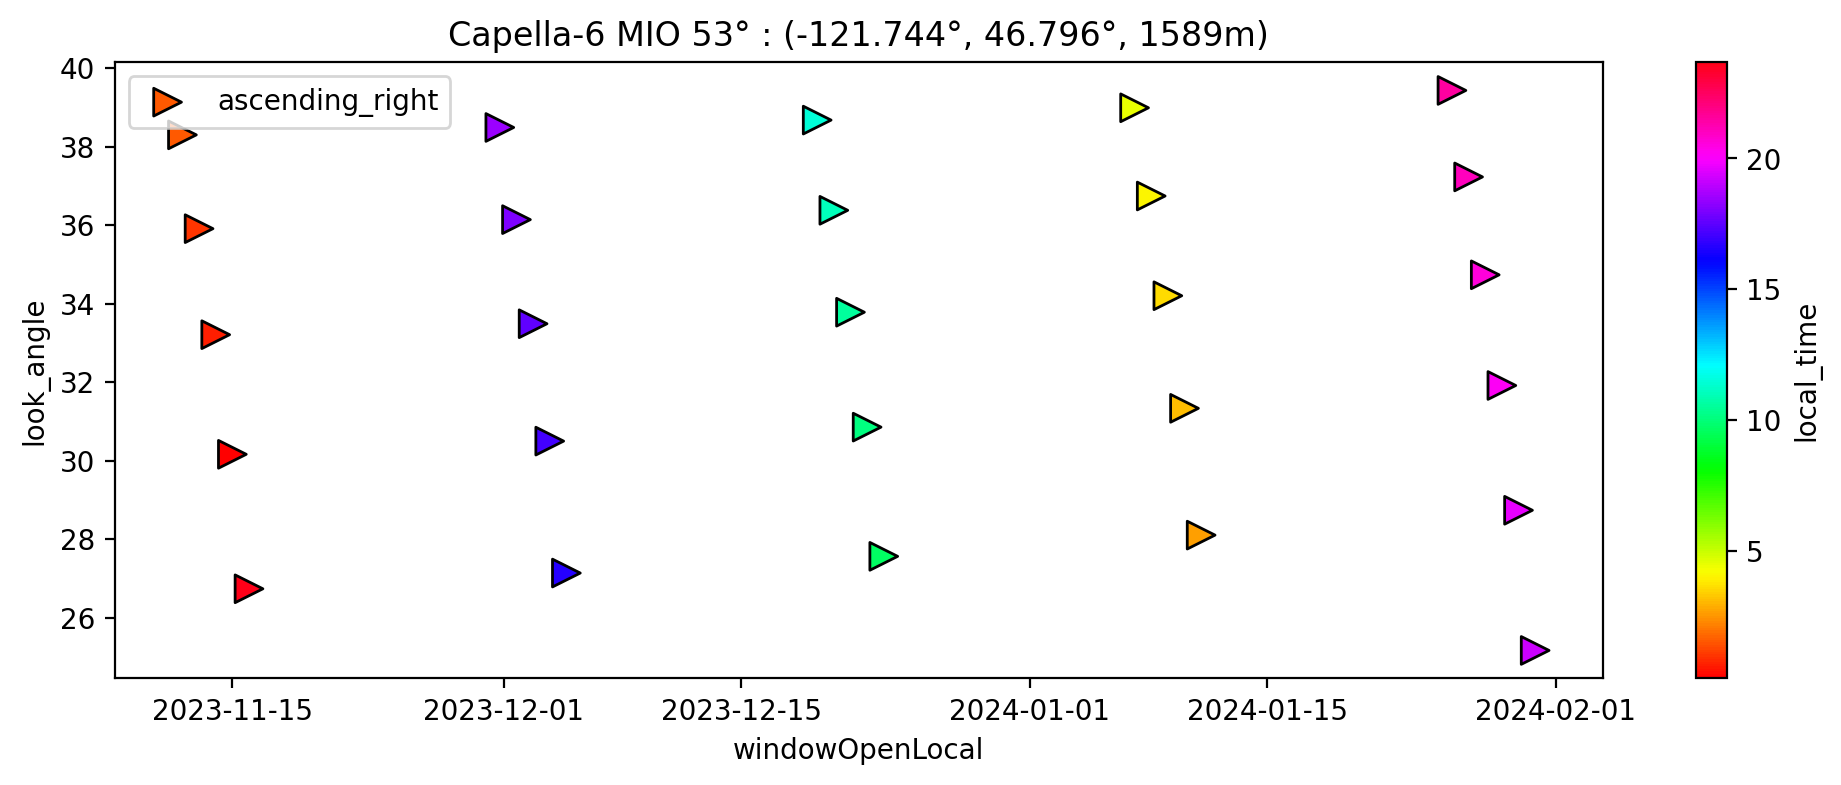

In [20]:
#ar.plot(x='windowOpenLocal', y='hour', marker='>', label='ascending_right');
#cmap = plt.cm.get_cmap('hsv', 23) More trouble than it's worth showing 24 discrete colors!
fig,ax = plt.subplots(figsize=(12,4))
ar.plot(kind='scatter', x='windowOpenLocal', y='look_angle', c='local_time', marker='>', s=100, edgecolors='k', label='ascending_right', ax=ax, cmap='hsv')
plt.title('Capella-6 MIO 53° : (-121.744°, 46.796°, 1589m)');

In [21]:
ar.windowOpenLocal

1    2023-11-12 01:30:16.139000+00:00
3    2023-11-13 01:02:47.163000+00:00
5    2023-11-14 00:35:21.310000+00:00
6    2023-11-15 00:07:57.160000+00:00
8    2023-11-15 23:40:34.236000+00:00
17   2023-11-30 18:29:48.565000+00:00
19   2023-12-01 18:02:19.095000+00:00
21   2023-12-02 17:34:52.986000+00:00
22   2023-12-03 17:07:28.634000+00:00
24   2023-12-04 16:40:05.526000+00:00
33   2023-12-19 11:29:20.385000+00:00
35   2023-12-20 11:01:50.413000+00:00
37   2023-12-21 10:34:24.066000+00:00
38   2023-12-22 10:06:59.557000+00:00
40   2023-12-23 09:39:36.313000+00:00
49   2024-01-07 04:28:53.078000+00:00
51   2024-01-08 04:01:22.170000+00:00
53   2024-01-09 03:33:55.502000+00:00
54   2024-01-10 03:06:30.803000+00:00
56   2024-01-11 02:39:07.430000+00:00
66   2024-01-25 21:28:27.994000+00:00
68   2024-01-26 21:00:55.109000+00:00
70   2024-01-27 20:33:27.947000+00:00
71   2024-01-28 20:06:02.991000+00:00
73   2024-01-29 19:38:39.453000+00:00
75   2024-01-30 19:11:17.006000+00:00
Name: window

In [22]:
# TOtal days considered
first = ar.windowOpenLocal.iloc[0]
last = ar.windowOpenLocal.iloc[-1]
print(first, last, last-first)

2023-11-12 01:30:16.139000+00:00 2024-01-30 19:11:17.006000+00:00 79 days 17:41:00.867000


In [23]:
# Subsequent Acquisition is X Minutes earlier per day:
minutes_per_day = -(pd.Timedelta(days=1) - ar.windowOpenLocal.diff(1)) / pd.Timedelta(minutes=1)
minutes_per_day[minutes_per_day<0].describe()

count    21.000000
mean    -27.433056
std       0.048913
min     -27.548083
25%     -27.452700
50%     -27.415933
75%     -27.392300
max     -27.374117
Name: windowOpenLocal, dtype: float64

In [24]:
# How many days to return to same acquisition time?
(24*60)/27.43

52.497265767407946